In [1]:
# This code can be downloaded as a Python script and run as:
# python full_vs_EM_any_dataset.py random_state dataset_name test_proportion val_proportion M_method M_alpha M_beta
#     test_proportion: The test proportion is from all the available true labels
#     val_proportion: The validation proportion is from the remaining training proportion with the true labels

def is_interactive():
    import __main__ as main
    return not hasattr(main, '__file__')

import sys

if is_interactive():
    %matplotlib inline
    sys.path.append('../')
    random_state = 0
    dataset_name = 'make_classification'
    prop_test = 0.8
    prop_val = 0.5
    M_method_list = ['noisy', 'quasi_IPL', 'random_weak', 'random_noise'] # IPL, quasi_IPL, random_weak, random_noise, noisy, supervisedg
    M_alpha = 0.7 # Alpha = 1.0 No unsupervised in IPL
    M_beta = 0.3 # Beta = 0.0 No noise
    data_folder = '../data/'
    max_epochs = 2000
else:
    
    random_state = int(sys.argv[1])
    dataset_name = sys.argv[2]
    prop_test = float(sys.argv[3])
    prop_val = float(sys.argv[4])
    max_epochs = int(sys.argv[5])
    M_method_list = ['noisy', 'quasi_IPL', 'random_weak', 'random_noise']
    if len(sys.argv) > 6:
        M_alpha = float(sys.argv[6])
    else:
        M_alpha = 0.8
    M_beta = 1 - M_alpha
    data_folder = './data/'
    print(locals())

import numpy
from experiments.data import make_weak_true_partition
from wlc.WLweakener import computeM, weak_to_index, estimate_M, generateWeak
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from experiments.models import create_model, MyKerasClassifier
import inspect
from keras.callbacks import EarlyStopping

import matplotlib
matplotlib.use('Agg')

import matplotlib.pyplot as plt
from matplotlib import cm

from experiments.visualizations import plot_heatmap
from experiments.visualizations import plot_confusion_matrix

plt.rcParams['figure.figsize'] = (5, 4)
plt.rcParams["figure.dpi"] = 100

cmap = cm.get_cmap('Accent')

from cycler import cycler
default_cycler = (cycler(color=['darkred', 'forestgreen', 'darkblue', 'violet', 'darkorange', 'saddlebrown']) +
                  cycler(linestyle=['-', '--', '-.', '-', '--', '-.']) + 
                  cycler(marker=['o', 'v', 'x', '*', '+', '.']) +
                  cycler(lw=[2, 1.8, 1.6, 1.4, 1.2, 1]))

plt.rc('lines', linewidth=1)
plt.rc('axes', prop_cycle=default_cycler)

Using TensorFlow backend.


# 1.a. Load data

The following data may contain weak, true labels or both ($S_w$, $S_t$ and $S_wt$ respectively).

- **PLEASE NOTE**: The current assumption is that the data is originally completly clean, or weak and weak+clean. But there is no current data with weak, weak+clean and clean. If at any point we have an example of that case we will need to rethinkg part of **Section 1**.

In [2]:
numpy.random.seed(random_state)

from sklearn.datasets import make_classification, make_blobs, load_digits
from experiments.data import load_webs, load_labelme, load_mnist, load_cifar10
from experiments.data import load_dataset_apply_model
from sklearn.naive_bayes import GaussianNB
    
n_samples = 5000
n_features = 20
n_classes = 3
true_size = 0.4
only_weak = ()
weak_and_true = ()
only_true = ()

if dataset_name == 'digits':
    true_size = 0.1
    X_t, y_t = load_digits(return_X_y=True)
    n_classes = 10
    true_size = 0.4
    classes = list(range(n_classes))
    n_features = X_t.shape[1]
    only_true = (X_t, y_t)
elif dataset_name == 'blobs':
    n_classes = 4
    classes = list(range(n_classes))
    n_samples = 20000
    true_size = 0.3
    n_features = 60
    centers = numpy.random.rand(n_classes, n_features)*n_features
    cluster_std = numpy.abs(numpy.random.randn(n_classes)*n_features)
    X_t, y_t = make_blobs(n_samples=n_samples, n_features=n_features, centers=centers,
                      cluster_std=cluster_std, random_state=random_state)
    only_true = (X_t, y_t)
elif dataset_name == 'make_classification':
    n_classes = 12
    classes = list(range(n_classes))
    n_features = 100
    n_samples = 10000
    n_redundant = 0
    n_clusters_per_class = 1
    n_informative = n_features
    X_t, y_t = make_classification(n_samples=n_samples, n_features=n_features,
                               n_classes=n_classes, random_state=random_state,
                               n_redundant=n_redundant,
                               n_informative=n_informative,
                               n_clusters_per_class=n_clusters_per_class)
    only_true = (X_t, y_t)
elif dataset_name == 'quasi_separable':
    
    means = [[-1, 0],
             [-1, 1],
             [ 1, 1]]
    n_classes = len(means)
    classes = list(range(n_classes))
    std = 1.0
    priors = numpy.array([1/3, 1/3, 1/3])
    samples_per_class = (n_samples*priors).astype(int)
    X_t, y_t = make_blobs(n_samples=samples_per_class, n_features=n_features, centers=means,
                      cluster_std=std, random_state=random_state)
    only_true = (X_t, y_t)
    n_features = X_t.shape[1]
elif dataset_name == 'separable':
    
    means = [[-1, 0],
             [-1, 1],
             [ 1, 1]]
    n_classes = len(means)
    classes = list(range(n_classes))
    std = .5
    priors = numpy.array([1/3, 1/3, 1/3])
    samples_per_class = (n_samples*priors).astype(int)
    X_t, y_t = make_blobs(n_samples=samples_per_class, n_features=n_features, centers=means,
                      cluster_std=std, random_state=random_state)
    only_true = (X_t, y_t)
    n_features = X_t.shape[1]
elif dataset_name == 'non_separable':
    std = 2.0
    n_features = 5
    X_t, y_t =  make_blobs(n_samples=n_samples, n_features=n_features, centers=12,
                           cluster_std=std, random_state=random_state)
    y_t[y_t < 5] = 0
    y_t[y_t > 7] = 1
    y_t[y_t > 1] = 2
    only_true = (X_t, y_t)
    n_classes = 3
    n_samples = X_t.shape[0]
elif dataset_name == 'webs':
    only_weak, weak_and_true, only_true, classes = load_webs(tfidf=True, standardize=True,
                                                #categories=['blog', 'inmo', 'parking', 'b2c', 'no_b2c', 'Other'],
                                                categories=['parking', 'b2c', 'no_b2c', 'Other'],
                                                random_state=random_state,
                                                folder=data_folder)
    X_w, Z_w, z_w, Y_w, y_w = only_weak
    X_wt, Z_wt, z_wt, Y_wt, y_wt = weak_and_true
    
    n_classes = Y_wt.shape[1]
    n_features = X_w.shape[1]
elif dataset_name == 'labelme':
    only_weak, weak_and_true, only_true, classes = load_labelme(
                                                random_state=random_state,
                                                folder=data_folder,
                                                keep_valid_test=False,
                                                prop_test=prop_test,
                                                prop_valid=prop_val)
    X_w, Z_w, z_w, Y_w, y_w = only_weak
    X_wt, Z_wt, z_wt, Y_wt, y_wt = weak_and_true
    X_t, Y_t, y_t = only_true
    
    n_classes = Y_wt.shape[1]
    n_features = X_w.shape[1]
elif dataset_name == 'iris_lr':
    
    only_weak, weak_and_true, only_true, classes = load_dataset_apply_model(dataset='iris', 
                                                                           true_proportion=0.3,
                                                                           clf=GaussianNB())
    X_w, Z_w, z_w, Y_w, y_w = only_weak
    X_wt, Z_wt, z_wt, Y_wt, y_wt = weak_and_true
    
    n_classes = Y_wt.shape[1]
    n_features = X_w.shape[1]
elif dataset_name == 'digits_lr':
    only_weak, weak_and_true, only_true, classes = load_dataset_apply_model(dataset='digits', 
                                                                           true_proportion=0.3,
                                                                           clf=GaussianNB())
    X_w, Z_w, z_w, Y_w, y_w = only_weak
    X_wt, Z_wt, z_wt, Y_wt, y_wt = weak_and_true
    
    n_classes = Y_wt.shape[1]
    n_features = X_w.shape[1]
elif dataset_name == 'mnist':
    X_t, y_t = load_mnist(random_state=random_state)
    X_t = X_t.reshape(X_t.shape[0], -1)
    print(y_t.shape)
    only_true = (X_t, y_t)
    n_classes = 10
    classes = list(range(n_classes))
    n_features = X_t.shape[1]
elif dataset_name == 'cifar10':
    X_t, y_t = load_cifar10(random_state=random_state)
    X_t = X_t.reshape(X_t.shape[0], -1)
    y_t = y_t.reshape(-1, )
    only_true = (X_t, y_t)
    n_classes = 10
    classes = list(range(n_classes))
    n_features = X_t.shape[-1]
else:
    raise KeyError('Dataset {} not available'.format(dataset_name))

n_only_weak = 0 if not only_weak else only_weak[0].shape[0]
n_weak_and_true = 0 if not weak_and_true else weak_and_true[0].shape[0]
n_only_true = 0 if not only_true else only_true[0].shape[0]

n_samples = n_only_weak + n_weak_and_true + n_only_true

print('Number of features = {}'.format(n_features))
print('Number of classes = {}'.format(n_classes))
print('Class names = {}'.format(classes))
print('Samples with only weak labels = {}'.format(n_only_weak))
print('Samples with weak and true labels = {}'.format(n_weak_and_true))
print('Samples with only true labels = {}'.format(n_only_true))

Number of features = 100
Number of classes = 12
Class names = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
Samples with only weak labels = 0
Samples with weak and true labels = 0
Samples with only true labels = 10000


# 1.b. Create synthetic weak labels

If the dataset does not have weak labels we will generate a random mixing matrix and generate weak labels for some of the samples.

In [3]:
from sklearn.preprocessing import label_binarize

sss = StratifiedShuffleSplit(n_splits=1, random_state=random_state,
                             train_size=(1. - prop_test),
                             test_size=prop_test)

Y_t = label_binarize(y_t, range(n_classes))
train_indx, test_indx = next(sss.split(X_t, y_t))

# train partition
X_wt, y_wt, Y_wt = X_t[train_indx], y_t[train_indx], Y_t[train_indx]
# test partition
X_t, y_t, Y_t = X_t[test_indx], y_t[test_indx], Y_t[test_indx]

X_wt_list = numpy.array_split(X_wt, len(M_method_list))
y_wt_list = numpy.array_split(y_wt, len(M_method_list))
Y_wt_list = numpy.array_split(Y_wt, len(M_method_list))

n_t_samples = len(y_t)
print('Test set size = {}'.format(n_t_samples))
n_wt_samples = sum([len(y_wt_list[i]) for i in range(len(y_wt_list))])
print('Training + Validation set size = {}'.format(n_wt_samples))
n_wt_samples_train = int(n_wt_samples*prop_val)
n_wt_samples_val = int(n_wt_samples*(1 - prop_val))
print('Training set size = {}'.format(n_wt_samples_train))
print('Validation set size = {}'.format(n_wt_samples_val))

Test set size = 8000
Training + Validation set size = 1999
Training set size = 999
Validation set size = 999


In [4]:
from wlc.WLweakener import computeM, generateWeak, binarizeWeakLabels

M_list = []
z_wt_list = []
Z_wt_list = []
for i, M_method in enumerate(M_method_list):
    M_list.append(computeM(n_classes, method=M_method, alpha=M_alpha, beta=M_beta,
             seed=(random_state+1)*i))

    print('Mixing matrix for set {}\n{}'.format(i, numpy.round(M_list[-1], decimals=3)))
    
    z_wt_list.append(generateWeak(y_wt_list[i], M_list[i]))
    Z_wt_list.append(binarizeWeakLabels(z_wt_list[i], n_classes))
    print('Sample of z labels\n{}'.format(z_wt_list[-1][:3]))
    print('Sample of Z labels\n{}'.format(Z_wt_list[-1][:3]))

Mixing matrix for set 0
[[0.7   0.027 0.027 0.027 0.027 0.027 0.027 0.027 0.027 0.027 0.027 0.027]
 [0.027 0.7   0.027 0.027 0.027 0.027 0.027 0.027 0.027 0.027 0.027 0.027]
 [0.027 0.027 0.7   0.027 0.027 0.027 0.027 0.027 0.027 0.027 0.027 0.027]
 [0.027 0.027 0.027 0.7   0.027 0.027 0.027 0.027 0.027 0.027 0.027 0.027]
 [0.027 0.027 0.027 0.027 0.7   0.027 0.027 0.027 0.027 0.027 0.027 0.027]
 [0.027 0.027 0.027 0.027 0.027 0.7   0.027 0.027 0.027 0.027 0.027 0.027]
 [0.027 0.027 0.027 0.027 0.027 0.027 0.7   0.027 0.027 0.027 0.027 0.027]
 [0.027 0.027 0.027 0.027 0.027 0.027 0.027 0.7   0.027 0.027 0.027 0.027]
 [0.027 0.027 0.027 0.027 0.027 0.027 0.027 0.027 0.7   0.027 0.027 0.027]
 [0.027 0.027 0.027 0.027 0.027 0.027 0.027 0.027 0.027 0.7   0.027 0.027]
 [0.027 0.027 0.027 0.027 0.027 0.027 0.027 0.027 0.027 0.027 0.7   0.027]
 [0.027 0.027 0.027 0.027 0.027 0.027 0.027 0.027 0.027 0.027 0.027 0.7  ]]
Sample of z labels
[256   4   2]
Sample of Z labels
[[0 0 0 1 0 0 0 0 0 0 0

# 1.c. Show weak and true samples

In the following plots we show only the 2 features with most variance on every set

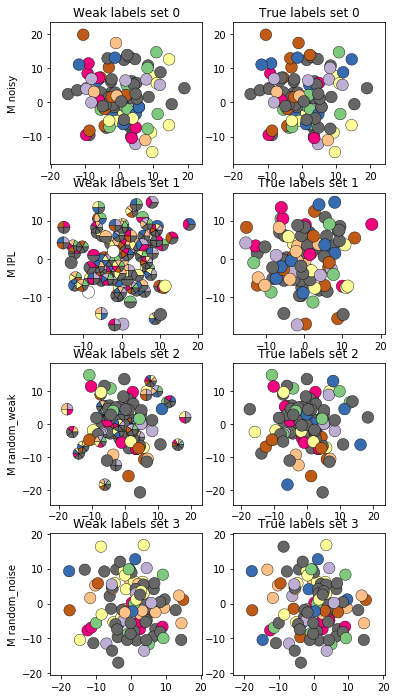

In [6]:
from experiments.visualizations import plot_multilabel_scatter

fig = plt.figure(figsize=(6, len(Z_wt_list)*3))
j = 1
for i in range(len(Z_wt_list)):
    ax = fig.add_subplot(len(Z_wt_list), 2, j)
    _ = plot_multilabel_scatter(X_wt_list[i][:100, ], Z_wt_list[i][:100], fig=fig,
                                ax=ax, title='Weak labels set {}'.format(i), cmap=cmap)
    ax.set_ylabel('M {}'.format(M_method_list[i]))
    ax = fig.add_subplot(len(Z_wt_list), 2, j+1)
    _ = plot_multilabel_scatter(X_wt_list[i][:100], Y_wt_list[i][:100], fig=fig,
                                ax=ax, title='True labels set {}'.format(i), cmap=cmap)
    j += 2

# 1.d. Divide weak labels into train and validation sets

If there is a set with only true labels, it is ussed always as a test set only (not validation)

In [7]:
X_wt_train_list = []
y_wt_train_list = []
Y_wt_train_list = []
z_wt_train_list = []
Z_wt_train_list = []

X_wt_val_list = []
y_wt_val_list = []
Y_wt_val_list = []
z_wt_val_list = []
Z_wt_val_list = []

for i in range(len(y_wt_list)):
    # We will use half of the train data for validation
    sss = StratifiedShuffleSplit(n_splits=1, random_state=random_state,
                                 train_size=(1. - prop_val),
                                 test_size=prop_val)

    train_indx, val_indx = next(sss.split(X_wt_list[i], y_wt_list[i]))
    # Validation partition
    X_wt_train_list.append(X_wt_list[i][train_indx])
    y_wt_train_list.append(y_wt_list[i][train_indx])
    Y_wt_train_list.append(Y_wt_list[i][train_indx])
    z_wt_train_list.append(z_wt_list[i][train_indx])
    Z_wt_train_list.append(Z_wt_list[i][train_indx])
    # Validation partition
    X_wt_val_list.append(X_wt_list[i][val_indx])
    y_wt_val_list.append(y_wt_list[i][val_indx])
    Y_wt_val_list.append(Y_wt_list[i][val_indx])
    z_wt_val_list.append(z_wt_list[i][val_indx])
    Z_wt_val_list.append(Z_wt_list[i][val_indx])

# 2.a. Train Scikit learn baselines

## 2.a.1. Upperbound if we have access to the full true labels

- This trains with all the following partitions
    - $S_w$
    - $S_{wt.train}$
    - $S_{wt.val}$

max_epochs = 2000

if y_w is not None:
    X_aux_train = numpy.concatenate((X_w, X_wt_train, X_wt_val))
    y_aux_train = numpy.concatenate((y_w, y_wt_train, y_wt_val))
    LR = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=max_epochs, penalty='l2', C=0.01)
    LR.fit(X_aux_train, y_aux_train)
    print('A Logistic Regression trained with all the real labels ({} samples)'.format(y_aux_train.shape[0]))
    acc_upperbound = LR.score(X_wt_test, y_wt_test)
    print('Accuracy = {}'.format(acc_upperbound))

    fig = plt.figure(figsize=(8,3))
    clf_pred =  LR.predict(X_aux_train)
    cm = confusion_matrix(y_aux_train, clf_pred)
    acc = (y_aux_train == clf_pred).mean()
    ax = fig.add_subplot(1, 2, 1)
    _ = plot_confusion_matrix(cm, ax=ax, title='Training acc. {:.3}'.format(acc))

    clf_pred =  LR.predict(X_wt_test)
    cm = confusion_matrix(y_wt_test, clf_pred)
    acc = (y_wt_test == clf_pred).mean()
    ax = fig.add_subplot(1, 2, 2)
    _ = plot_confusion_matrix(cm, ax=ax, title='Test acc. {:.3}'.format(acc))

## 2.a.2. Lowerbound if we have access to a limited set of true labels


- This trains with all the following partitions
    - $S_{wt.train}$
    - $S_{wt.val}$

max_epochs = 2000

X_aux_train = numpy.concatenate((X_wt_train, X_wt_val))
y_aux_train = numpy.concatenate((y_wt_train, y_wt_val))
LR = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=max_epochs, penalty='l2', C=0.01)
LR.fit(X_aux_train, y_aux_train)
print('A Logistic Regression trained with all the real labels ({} samples)'.format(y_aux_train.shape[0]))
acc_upperbound = LR.score(X_wt_test, y_wt_test)
print('Accuracy = {}'.format(acc_upperbound))

fig = plt.figure(figsize=(8,3))
clf_pred =  LR.predict(X_aux_train)
cm = confusion_matrix(y_aux_train, clf_pred)
acc = (y_aux_train == clf_pred).mean()
ax = fig.add_subplot(1, 2, 1)
_ = plot_confusion_matrix(cm, ax=ax, title='Training acc. {:.3}'.format(acc))

clf_pred =  LR.predict(X_wt_test)
cm = confusion_matrix(y_wt_test, clf_pred)
acc = (y_wt_test == clf_pred).mean()
ax = fig.add_subplot(1, 2, 2)
_ = plot_confusion_matrix(cm, ax=ax, title='Test acc. {:.3}'.format(acc))

# 2.b. Train Keras baselines

**TODO: check what happens when there is a typo on the early_stop_loss**


In [8]:
from keras.models import Sequential
from keras.layers import Dense
from keras import backend as K
from keras import regularizers

_EPSILON = K.epsilon()

def log_loss(y_true, y_pred):
    y_pred = K.clip(y_pred, _EPSILON, 1.0-_EPSILON)
    out = -y_true*K.log(y_pred)
    return K.mean(out, axis=-1)

def make_model_lr(loss):
    model = Sequential() 
    model.add(Dense(n_classes, input_dim=n_features, activation='softmax',
                bias_initializer='zeros', 
                kernel_regularizer=regularizers.l2(1.0),
                kernel_initializer='glorot_normal'))
    model.compile(optimizer='adam', loss=loss,
                  metrics=['accuracy', 'mean_squared_error',
                           'categorical_crossentropy'])
    print('Sample of first weights = {}'.format(numpy.round(model.get_weights()[0][0], decimals=3)))
    return model

def make_model_mlp(loss):
    model = Sequential() 
    model.add(Dense(20, input_dim=n_features))
    model.add(Dense(20))
    model.add(Dense(n_classes, activation='softmax'))
    model.compile(optimizer='adam', loss=loss,
                  metrics=['accuracy', 'mean_squared_error',
                           'categorical_crossentropy'])
    print('Sample of first weights = {}'.format(numpy.round(model.get_weights()[0][0], decimals=3)))
    return model

make_model = make_model_lr

from keras.callbacks import EarlyStopping

batch_size = 2048
patience = int(max_epochs/6)
early_stop_loss = 'val_categorical_crossentropy' # TODO Check what happens when there is a typo in this loss

early_stopping = EarlyStopping(monitor=early_stop_loss, min_delta=0, patience=patience, 
                               verbose=1, mode='auto', baseline=None,
                               restore_best_weights=True)

def plot_results(model, X_test, y_test, history):
    if not is_interactive():
        return
    
    clf_proba_wt_test = model.predict_proba(X_test)
    clf_pred_wt_test = numpy.argmax(clf_proba_wt_test, axis=1)
    cm = confusion_matrix(y_test, clf_pred_wt_test)

    fig = plt.figure(figsize=(16, 3))
    n_fig = 5
    ax = fig.add_subplot(1, n_fig, 1)
    _ = ax.plot(history.history['loss'], label='Training loss')
    _ = ax.plot(history.history['val_loss'], label='Validation loss')
    ax.set_yscale("symlog")
    #ax.set_xscale("symlog")
    ax.legend()
    ax = fig.add_subplot(1, n_fig, 2)
    _ = ax.plot(history.history['categorical_crossentropy'], label='Training CE')
    _ = ax.plot(history.history['val_categorical_crossentropy'], label='Validation CE')
    ax.set_yscale("symlog")
    #ax.set_xscale("symlog")
    ax.legend()
    ax = fig.add_subplot(1, n_fig, 3)
    _ = ax.plot(history.history['mean_squared_error'], label='Training MSE')
    _ = ax.plot(history.history['val_mean_squared_error'], label='Validation MSE')
    ax.set_yscale("symlog")
    #ax.set_xscale("symlog")
    ax.legend()
    ax = fig.add_subplot(1, n_fig, 4)
    _ = ax.plot(history.history['acc'], label='Training acc')
    _ = ax.plot(history.history['val_acc'], label='Validation acc')
    #ax.set_xscale("symlog")
    ax.legend()
    ax = fig.add_subplot(1, n_fig, 5)
    acc = (y_test == clf_pred_wt_test).mean()
    _ = plot_confusion_matrix(cm, ax=ax, title='Test acc. {:.3}'.format(acc))

## 2.b.2. Upperbound if multiple true labels are available

Training Upperbound
Sample of first weights = [ 0.171 -0.117  0.053 -0.048 -0.186  0.022 -0.26   0.121  0.068 -0.076
  0.268 -0.182]
A Keras Logistic Regression trained with all the real labels (999 samples)
Accuracy = 0.459


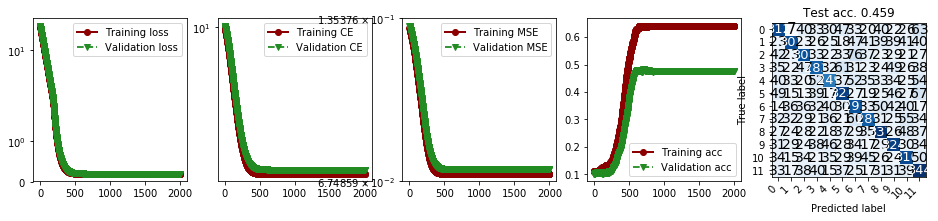

<Figure size 360x288 with 0 Axes>

In [9]:
print('Training Upperbound')
numpy.random.seed(random_state)
model = make_model(log_loss)

X_aux_train = numpy.concatenate(X_wt_train_list)
Y_aux_train = numpy.concatenate(Y_wt_train_list)
X_aux_val = numpy.concatenate(X_wt_val_list)
Y_aux_val = numpy.concatenate(Y_wt_val_list)
history = model.fit(X_aux_train, Y_aux_train, 
                    validation_data=(X_aux_val, Y_aux_val),
                    epochs=max_epochs, verbose=0, callbacks=[early_stopping],
                    batch_size=batch_size, shuffle=True)

plot_results(model, X_t, y_t, history)

print('A Keras Logistic Regression trained with all the real labels ({} samples)'.format(Y_aux_train.shape[0]))
acc_upperbound = (model.predict_proba(X_t).argmax(axis=1) == y_t).mean()
print('Accuracy = {}'.format(acc_upperbound))

## 2.b.2. Lowerbound with a small amount of true labels

numpy.random.seed(random_state)
model = make_model(log_loss)

print('Training Lowerbound')
print('Sample of train labels = {}'.format(numpy.round(Y_wt_train[:2], decimals=2)))
print('Sample of validation labels = {}'.format(numpy.round(Y_wt_val[:2], decimals=2)))
history = model.fit(X_wt_train, Y_wt_train, 
                    validation_data=(X_wt_val, Y_wt_val),
                    epochs=max_epochs, verbose=0, callbacks=[early_stopping],
                    batch_size=batch_size, shuffle=True)

plot_results(model, X_wt_test, y_wt_test, history)

print('A Keras Logistic Regression trained with only training true labels ({} samples)'.format(Y_wt_train.shape[0]))
acc_lowerbound = (model.predict_proba(X_wt_test).argmax(axis=1) == y_wt_test).mean()
print('Accuracy = {}'.format(acc_lowerbound))

## 2.b.3. Training directly with different proportions of weak labels

In [10]:
list_weak_proportions = numpy.array([0.001, 0.005, 0.01, 0.02, 0.03, 0.05, 0.1, 0.3, 0.5, 0.7, 1.0])
list_weak_proportions = numpy.array([0.01, 0.1, 0.5, 1.0])
acc = {}

## 2.b.4. Training with different proportions of true labels if available

Training Upperbound with increasing number of true labels
Sample of first weights = [ 0.171 -0.117  0.053 -0.048 -0.186  0.022 -0.26   0.121  0.068 -0.076
  0.268 -0.182]
Sample of train labels = [[0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0]]
Sample of validation labels = [[0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0]]
Restoring model weights from the end of the best epoch
Epoch 00831: early stopping
Number of weak samples = 9 from total 9, Accuracy = 0.140
Sample of first weights = [ 0.171 -0.117  0.053 -0.048 -0.186  0.022 -0.26   0.121  0.068 -0.076
  0.268 -0.182]
Sample of train labels = [[0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0]]
Sample of validation labels = [[0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0]]
Restoring model weights from the end of the best epoch
Epoch 00922: early stopping
Number of weak samples = 99 from total 99, Accuracy = 0.255
Sample of first weights = [ 0.171 -0.117  0.053 -0.048 -0.186  0.022 -0.26   0.121  0.068 -0.076
  0.2

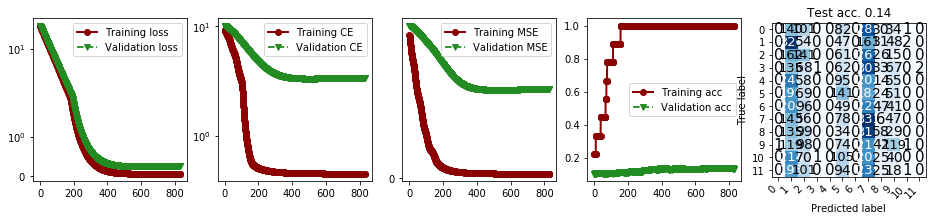

<Figure size 360x288 with 0 Axes>

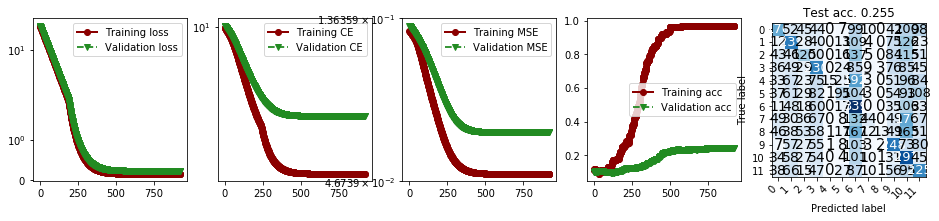

<Figure size 360x288 with 0 Axes>

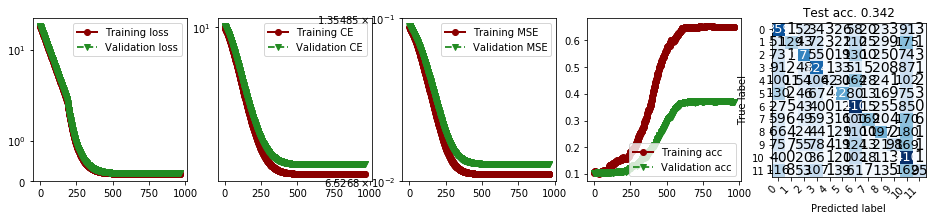

<Figure size 360x288 with 0 Axes>

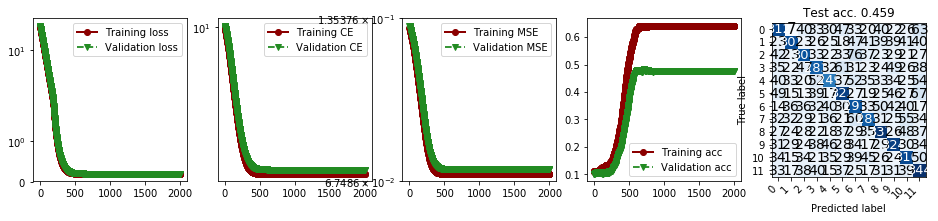

<Figure size 360x288 with 0 Axes>

In [ ]:
print('Training Upperbound with increasing number of true labels')
method = 'True'
acc[method] = numpy.zeros_like(list_weak_proportions)
X_aux_val = numpy.concatenate(X_wt_val_list)
Y_aux_val = numpy.concatenate(Y_wt_val_list)
for i, weak_proportion in enumerate(list_weak_proportions):
    X_aux_train = numpy.concatenate(X_wt_train_list)
    Y_aux_train = numpy.concatenate(Y_wt_train_list)

    last_index = int(weak_proportion*X_aux_train.shape[0])
    
    X_aux_train, Y_aux_train = shuffle(X_aux_train, Y_aux_train)
    X_aux_train = X_aux_train[:last_index]
    Y_aux_train = Y_aux_train[:last_index]

    numpy.random.seed(random_state)
    model = make_model(log_loss)

    print('Sample of train labels = {}'.format(numpy.round(Y_aux_train[:2], decimals=2)))
    print('Sample of validation labels = {}'.format(numpy.round(Y_aux_val[:2], decimals=2)))
    history = model.fit(X_aux_train, Y_aux_train,
                        validation_data=(X_aux_val, Y_aux_val),
                        epochs=max_epochs, verbose=0, callbacks=[early_stopping],
                        batch_size=batch_size, shuffle=True)
    # 5. Evaluate the model in the test set with true labels
    y_pred = model.predict(X_t).argmax(axis=1)
    acc[method][i] = (y_pred == y_t).mean()
    print('Number of weak samples = {} from total {}, Accuracy = {:.3f}'.format(last_index, Y_aux_train.shape[0], acc[method][i]))

    plot_results(model, X_t, y_t, history)

Training only with the weak labels
Sample of first weights = [ 0.171 -0.117  0.053 -0.048 -0.186  0.022 -0.26   0.121  0.068 -0.076
  0.268 -0.182]
Sample of train labels = [[0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0]]
Sample of validation labels = [[0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0]]
Restoring model weights from the end of the best epoch
Epoch 00836: early stopping
Number of weak samples = 9 from total 999, Accuracy = 0.127
Sample of first weights = [ 0.171 -0.117  0.053 -0.048 -0.186  0.022 -0.26   0.121  0.068 -0.076
  0.268 -0.182]
Sample of train labels = [[0 0 0 1 0 1 1 1 1 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 1]]
Sample of validation labels = [[0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0]]
Restoring model weights from the end of the best epoch
Epoch 00918: early stopping
Number of weak samples = 99 from total 999, Accuracy = 0.175
Sample of first weights = [ 0.171 -0.117  0.053 -0.048 -0.186  0.022 -0.26   0.121  0.068 -0.076
  0.268 -0.182]
Sample of

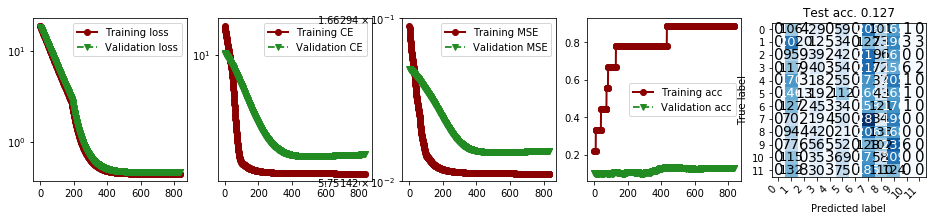

<Figure size 360x288 with 0 Axes>

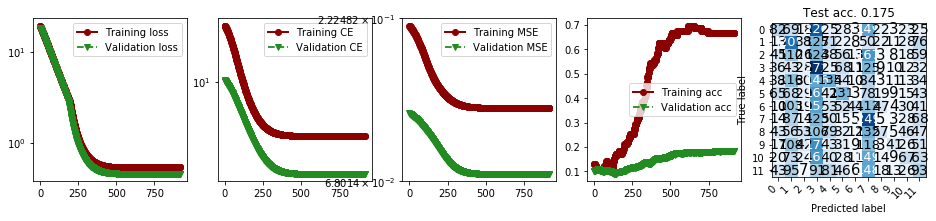

<Figure size 360x288 with 0 Axes>

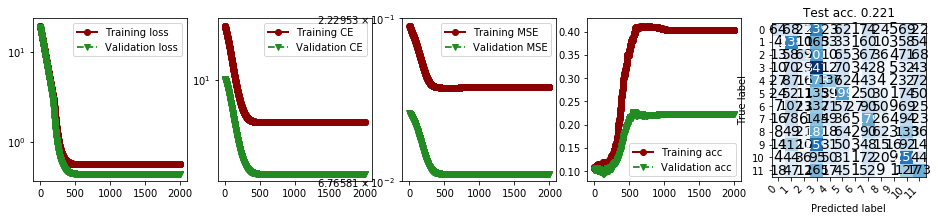

<Figure size 360x288 with 0 Axes>

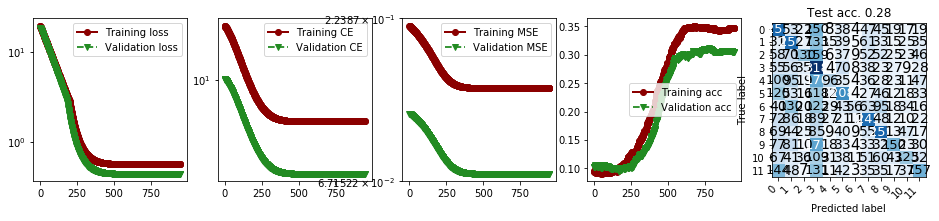

<Figure size 360x288 with 0 Axes>

In [ ]:
print('Training only with the weak labels')
method = 'Weak'
acc[method] = numpy.zeros_like(list_weak_proportions)
X_aux_val = numpy.concatenate(X_wt_val_list)
Y_aux_val = numpy.concatenate(Y_wt_val_list)
for i, weak_proportion in enumerate(list_weak_proportions):
    X_aux_train = numpy.concatenate(X_wt_train_list)
    Z_aux_train = numpy.concatenate(Z_wt_train_list)

    last_index = int(weak_proportion*X_aux_train.shape[0])
    
    X_aux_train, Z_aux_train = shuffle(X_aux_train, Z_aux_train)
    X_aux_train = X_aux_train[:last_index]
    Z_aux_train = Z_aux_train[:last_index]

    numpy.random.seed(random_state)
    model = make_model(log_loss)

    print('Sample of train labels = {}'.format(numpy.round(Z_aux_train[:2], decimals=2)))
    print('Sample of validation labels = {}'.format(numpy.round(Y_aux_val[:2], decimals=2)))
    history = model.fit(X_aux_train, Z_aux_train,
                        validation_data=(X_aux_val, Y_aux_val),
                        epochs=max_epochs, verbose=0, callbacks=[early_stopping],
                        batch_size=batch_size, shuffle=True)
    # 5. Evaluate the model in the test set with true labels
    y_pred = model.predict(X_t).argmax(axis=1)
    acc[method][i] = (y_pred == y_t).mean()
    print('Number of weak samples = {} from total {}, Accuracy = {:.3f}'.format(last_index, Y_aux_train.shape[0], acc[method][i]))

    plot_results(model, X_t, y_t, history)

# 3. Train EM

## 3.a. Learning mixing matrix M

categories = range(n_classes)
from wlc.WLweakener import newWeakCount
w_count = newWeakCount(Z_wt_train, Y_wt_train, range(n_classes), reg='Partial', Z_reg=Z_w, alpha=1).astype(int)
print("Weak count\n{}".format(w_count.todense()))
# 1.a. Learn a mixing matrix using training with weak and true labels
M_0 = estimate_M(Z_wt_train, Y_wt_train, range(n_classes), reg='Partial', Z_reg=Z_w, alpha=1)
M_1 = computeM(c=n_classes, method='supervised')
q_0 = X_w.shape[0] / float(X_w.shape[0] + X_wt_train.shape[0])
q_1 = X_wt_train.shape[0] / float(X_w.shape[0] + X_wt_train.shape[0])
M_EM = numpy.concatenate((q_0*M_0, q_1*M_1), axis=0)

print('q0 = {}, q1 = {}'.format(q_0, q_1))
print("M_0 shape = {}\n{}".format(M_0.shape, numpy.round(M_0, decimals=3)))
print("M_1 shape = {}\n{}".format(M_1.shape, numpy.round(M_1, decimals=3)))
print("M_EM shape = {}\n{}".format(M_EM.shape, numpy.round(M_EM, decimals=3)))
print("Z_wt\n{}".format(numpy.round(Z_wt_train[:5])))
print("Y_wt\n{}".format(numpy.round(Y_wt_train[:5])))

if M is not None:
    # 1.b. True mixing matrix
    M_T = numpy.concatenate((q_0*M, q_1*M_1), axis=0)
    print("M_T shape = {}\n{}".format(M_T.shape, numpy.round(M_T, decimals=3)))
    
    if M_T.shape == M_EM.shape:
        print('Mean Squared Difference between True and estimated M = {}'.format(numpy.mean(numpy.square(M_T - M_EM))))

    # FIXME problem here when true M is square and estimated is not
    m_list = [(r'Original $M$', M), (r'Weak Count', w_count.todense()),
              (r'Estimated $M_0$', M_0)]
    if M.shape == M_0.shape:
        m_list.append((r'$|M - M_0|$', numpy.abs(M - M_0)))
        
    fig = plt.figure(figsize=(10, 5))
    for i, (title, m_aux) in enumerate(m_list):
        ax = fig.add_subplot(1,len(m_list),i+1)
        if n_classes < 5:
            from wlc.WLweakener import binarizeWeakLabels
            rows = binarizeWeakLabels(numpy.arange(m_aux.shape[0]), c=m_aux.shape[1])
            fig = plot_heatmap(m_aux, rows=rows, title=title, fig=fig, ax=ax,
                               xlabel='True label', ylabel='Weak label')
        else:
            ax.imshow(m_aux, interpolation='nearest', aspect='auto')

## 3.b. Train with true mixing matrix M if available

In [ ]:
m = {}

def EM_log_loss(y_true, y_pred):
    y_pred = K.clip(y_pred, _EPSILON, 1.0-_EPSILON)
    Q = y_true * y_pred
    Z_em_train = Q / K.sum(Q, axis=-1, keepdims=True)
    out = -K.stop_gradient(Z_em_train)*K.log(y_pred)
    return K.mean(out, axis=-1)

### Index are different

- Be careful as the indices from the true matrix can be smaller than the estimated, as the estimated is always the long version while the original one can be square

Training EM M original
Mixing matrix M shape = (8216, 12)
[[0.7        0.02727273 0.02727273 ... 0.02727273 0.02727273 0.02727273]
 [0.02727273 0.7        0.02727273 ... 0.02727273 0.02727273 0.02727273]
 [0.02727273 0.02727273 0.7        ... 0.02727273 0.02727273 0.02727273]
 ...
 [0.04113882 0.03288417 0.02723572 ... 0.70699054 0.02488166 0.00251804]
 [0.00928229 0.0305081  0.03655743 ... 0.00281566 0.70497907 0.0492085 ]
 [0.02397391 0.03496524 0.00954657 ... 0.01418631 0.04452586 0.7081031 ]]
Sample of first weights = [ 0.171 -0.117  0.053 -0.048 -0.186  0.022 -0.26   0.121  0.068 -0.076
  0.268 -0.182]
Sample of train labels = [[ 10.71  13.77   8.43   3.84  -0.26  -1.54  -7.83   0.24   3.32   3.73
   -8.1   -1.03  -3.65  -4.71  -7.96   3.72   4.55   0.51  -6.17   9.
   -3.63   1.7   -1.14  -6.62  -2.84  -2.25   6.58 -15.14   1.58   0.16
  -10.11  -1.89   6.34  -8.44  -4.     2.2    1.46  -2.01  -5.81   5.26
    1.86   8.     5.79  -5.17  -9.35   4.02 -10.     1.78   1.    -3.39
  

Restoring model weights from the end of the best epoch
Epoch 00947: early stopping
Number of weak samples = 999 and true = 999, Accuracy = 0.291


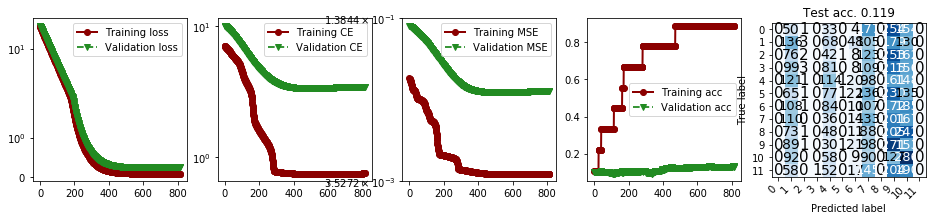

<Figure size 360x288 with 0 Axes>

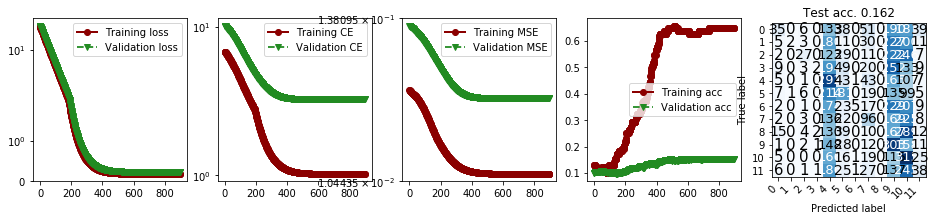

<Figure size 360x288 with 0 Axes>

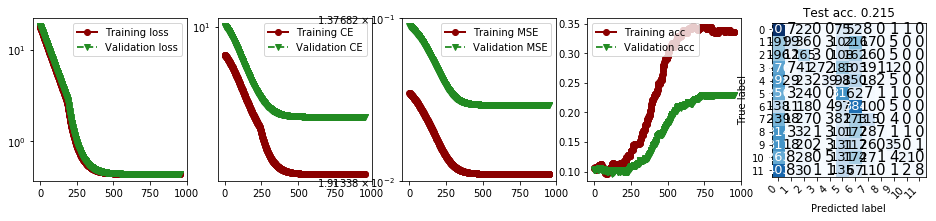

<Figure size 360x288 with 0 Axes>

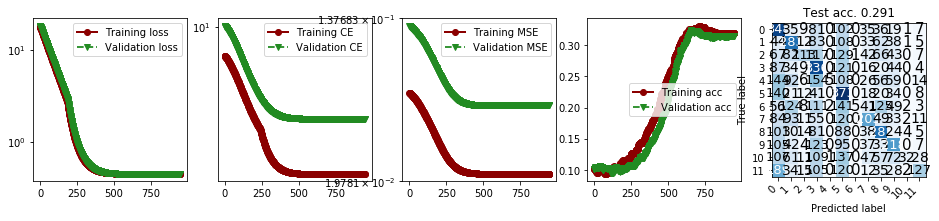

<Figure size 360x288 with 0 Axes>

In [ ]:
Z_wt_train_index_list = []
last_index = 0
M_T = numpy.concatenate(M_list)
for i in range(len(M_method_list)):
    Z_wt_train_index_list.append(last_index + weak_to_index(Z_wt_train_list[i], method=M_method_list[i]))
    last_index += len(M_list[i])

X_aux_val = numpy.concatenate(X_wt_val_list)
Y_aux_val = numpy.concatenate(Y_wt_val_list)
    
method = 'EM M original'
print('Training {}'.format(method))
acc[method] = numpy.zeros_like(list_weak_proportions)
m[method] = M_T
print('Mixing matrix M shape = {}'.format(m[method].shape))
print(m[method])
for i, weak_proportion in enumerate(list_weak_proportions):
    X_aux_train = numpy.concatenate(X_wt_train_list)
    Z_aux_train = numpy.concatenate(Z_wt_train_list)
    Z_aux_index = numpy.concatenate(Z_wt_train_index_list)

    last_index = int(weak_proportion*X_aux_train.shape[0])
    
    X_aux_train, Z_aux_train, Z_aux_index = shuffle(X_aux_train, Z_aux_train, Z_aux_index)
    X_aux_train = X_aux_train[:last_index]
    Z_aux_train = Z_aux_train[:last_index]
    Z_aux_index = Z_aux_index[:last_index]
    V_aux_train = m[method][Z_aux_index]

    numpy.random.seed(random_state)
    model = make_model(EM_log_loss)

    print('Sample of train labels = {}'.format(numpy.round(X_aux_train[:2], decimals=2)))
    print('Sample of validation labels = {}'.format(numpy.round(Y_aux_val[:2], decimals=2)))
    history = model.fit(X_aux_train, V_aux_train, 
                        validation_data=(X_aux_val, Y_aux_val),
                        epochs=max_epochs, verbose=0, callbacks=[early_stopping],
                        batch_size=batch_size, shuffle=True)
    # 5. Evaluate the model in the test set with true labels
    y_pred = model.predict(X_t).argmax(axis=1)
    acc[method][i] = (y_pred == y_t).mean()
    print('Number of weak samples = {} and true = {}, Accuracy = {:.3f}'.format(last_index, X_aux_train.shape[0], acc[method][i]))
    
    plot_results(model, X_t, y_t, history)

## 3.c. Train with estimated mixing matrix M_ME

../wlc/WLweakener.py:496: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  S[weak_list, :] = alpha


Training EM M estimated
Mixing matrix M shape = (8216, 12)
[[0.7        0.02727273 0.02727273 ... 0.02727273 0.02727273 0.02727273]
 [0.02727273 0.7        0.02727273 ... 0.02727273 0.02727273 0.02727273]
 [0.02727273 0.02727273 0.7        ... 0.02727273 0.02727273 0.02727273]
 ...
 [0.04113882 0.03288417 0.02723572 ... 0.70699054 0.02488166 0.00251804]
 [0.00928229 0.0305081  0.03655743 ... 0.00281566 0.70497907 0.0492085 ]
 [0.02397391 0.03496524 0.00954657 ... 0.01418631 0.04452586 0.7081031 ]]
Sample of first weights = [ 0.171 -0.117  0.053 -0.048 -0.186  0.022 -0.26   0.121  0.068 -0.076
  0.268 -0.182]
Sample of train labels = [[ -2.39  -3.6   -0.09  -9.    -3.24  -3.58 -11.59   3.98  -7.45  -7.54
   -8.82  11.76  -1.51  -4.73  14.52   7.43  -6.46  -6.79   4.48   5.54
   -2.27   6.3    4.34   1.68  -9.04   7.65 -14.43 -11.54   3.57  -1.95
    3.67  -0.18  -8.89   4.62   9.11  -8.57  -1.25   7.29   1.75  -2.65
   -2.71   6.29  -3.17   6.56  -0.95   2.03  -8.     9.91   2.48   7.53

Restoring model weights from the end of the best epoch
Epoch 00774: early stopping
Number of weak samples = 999 and true = 999, Accuracy = 0.079


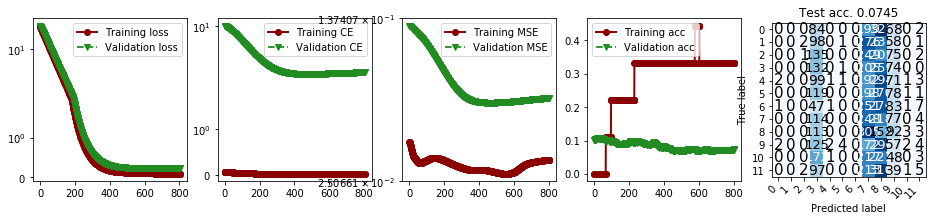

<Figure size 360x288 with 0 Axes>

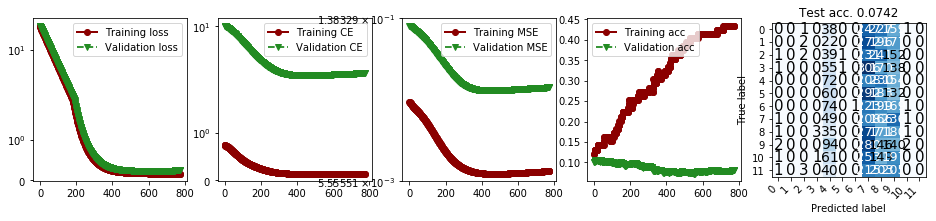

<Figure size 360x288 with 0 Axes>

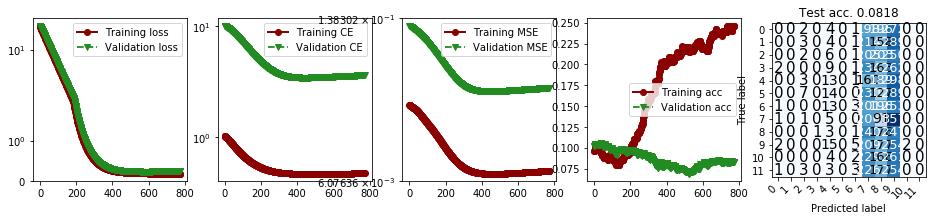

<Figure size 360x288 with 0 Axes>

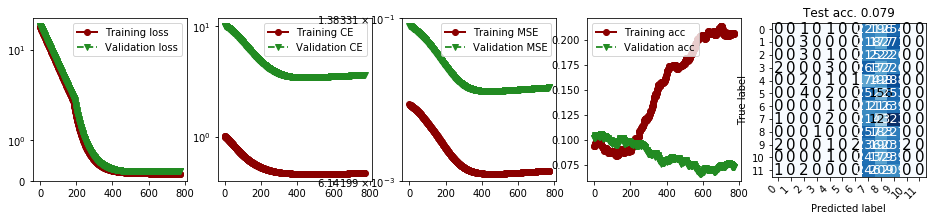

<Figure size 360x288 with 0 Axes>

In [ ]:
Z_wt_train_index_list = []
last_index = 0
M_E = numpy.concatenate(M_list)

M_E_list = []
for i in range(len(Y_wt_val_list)):
    M_E_list.append(estimate_M(Z_wt_val_list[i], Y_wt_val_list[i],
                               range(n_classes), reg='Partial', Z_reg=Z_wt_train_list[i], alpha=1))
    M_E_list[-1] *= len(Y_wt_val_list[i])/sum([len(Y_wt_val_list[j]) for j in range(len(Y_wt_val_list))])
    
for i in range(len(M_method_list)):
    Z_wt_train_index_list.append(last_index + weak_to_index(Z_wt_train_list[i], method='Mproper'))
    last_index += len(M_E[i])

X_aux_val = numpy.concatenate(X_wt_val_list)
Y_aux_val = numpy.concatenate(Y_wt_val_list)
    
method = 'EM M estimated'
print('Training {}'.format(method))
acc[method] = numpy.zeros_like(list_weak_proportions)
m[method] = M_E
print('Mixing matrix M shape = {}'.format(m[method].shape))
print(m[method])
for i, weak_proportion in enumerate(list_weak_proportions):
    X_aux_train = numpy.concatenate(X_wt_train_list)
    Z_aux_train = numpy.concatenate(Z_wt_train_list)
    Z_aux_index = numpy.concatenate(Z_wt_train_index_list)

    last_index = int(weak_proportion*X_aux_train.shape[0])
    
    X_aux_train, Z_aux_train, Z_aux_index = shuffle(X_aux_train, Z_aux_train, Z_aux_index)
    X_aux_train = X_aux_train[:last_index]
    Z_aux_train = Z_aux_train[:last_index]
    Z_aux_index = Z_aux_index[:last_index]
    V_aux_train = m[method][Z_aux_index]

    numpy.random.seed(random_state)
    model = make_model(EM_log_loss)

    print('Sample of train labels = {}'.format(numpy.round(X_aux_train[:2], decimals=2)))
    print('Sample of validation labels = {}'.format(numpy.round(Y_aux_val[:2], decimals=2)))
    history = model.fit(X_aux_train, V_aux_train, 
                        validation_data=(X_aux_val, Y_aux_val),
                        epochs=max_epochs, verbose=0, callbacks=[early_stopping],
                        batch_size=batch_size, shuffle=True)
    # 5. Evaluate the model in the test set with true labels
    y_pred = model.predict(X_t).argmax(axis=1)
    acc[method][i] = (y_pred == y_t).mean()
    print('Number of weak samples = {} and true = {}, Accuracy = {:.3f}'.format(last_index, X_aux_train.shape[0], acc[method][i]))
    
    plot_results(model, X_t, y_t, history)

## 3.d. Training with virtual labels

Z_w_index = weak_to_index(Z_w, method='random_weak')
Y_wt_train_index = weak_to_index(Y_wt_train, method='supervised')

print("Z_w_index {}".format(Z_w_index[:5]))
print('Y_wt_train_index {}'.format(Y_wt_train_index[:5]))

method = 'Virtual M estimated'
acc[method] = numpy.zeros_like(list_weak_proportions)
m[method] = M_EM
print('Mixing matrix M shape = {}'.format(m[method].shape))
print(m[method])
for i, weak_proportion in enumerate(list_weak_proportions):
    last_index = int(weak_proportion*Z_w.shape[0])
    
    X_wt_aux = numpy.concatenate((X_w[:last_index], X_wt_train))
    ZY_wt_aux_index = numpy.concatenate((Z_w_index[:last_index], Y_wt_train_index + M_0.shape[0]))
    
    # Change weights q for the actual sizes
    q_0 = last_index / float(last_index + X_wt_train.shape[0])
    q_1 = X_wt_train.shape[0] / float(last_index + X_wt_train.shape[0])
    print("Size set weak = {:.0f}, size set true = {:.0f}".format(last_index, X_wt_train.shape[0]))
    print("q_0 = {}, q_1 = {}".format(q_0, q_1))
    m_aux = numpy.concatenate((q_0*M_0, q_1*M_1), axis=0)
    #m_aux = M_EM # numpy.concatenate((q_0*M_0, q_1*M_1), axis=0)
    
        
    V_aux = numpy.linalg.pinv(m_aux)
    print(V_aux)
    
    ZY_wt_aux = V_aux.T[ZY_wt_aux_index]
    
    #print(m_aux)
    #ZY_wt_aux = m_aux[ZY_wt_aux_index]

    numpy.random.seed(random_state)
    model = make_model('mse')

    print('Sample of train labels = {}'.format(numpy.round(ZY_wt_aux[:2], decimals=2)))
    print('Sample of validation labels = {}'.format(numpy.round(Y_wt_val[:2], decimals=2)))
    history = model.fit(X_wt_aux, ZY_wt_aux, 
                        validation_data=(X_wt_val, Y_wt_val),
                        epochs=max_epochs, verbose=0, callbacks=[early_stopping],
                        batch_size=batch_size, shuffle=True)
    # 5. Evaluate the model in the test set with true labels
    y_pred = model.predict(X_wt_test).argmax(axis=1)
    acc[method][i] = (y_pred == y_wt_test).mean()
    print('Number of weak samples = {} and true = {}, Accuracy = {:.3f}'.format(last_index, X_wt_train.shape[0], acc[method][i]))

    
    plot_results(model, X_wt_test, y_wt_test, history)

## 4. Baseline Optimistic Superset Learning

- uses the predictions for the weak labels
- **TODO** This function assumes there are no fully unsupervised samples!!! The current approach will assign 1/n_zeros as the weak label (this may not be bad, if we assume that it needs to belong to one of the classes).

In [ ]:
def OSL_log_loss(y_true, y_pred):
    # Careful, I had to use a global variable here for the number of classes
    # for some reason I can not use y_osl.shape[-1] in the reshape function
    y_pred = K.clip(y_pred, _EPSILON, 1.0-_EPSILON)
    y_osl = y_true * y_pred
    y_osl_max = K.max(y_osl, axis=-1)
    y_osl_max = K.repeat_elements(y_osl_max, n_classes, 0)
    y_osl_max = K.reshape(y_osl_max, (-1, n_classes))
    y_osl = K.cast(K.equal(y_osl, y_osl_max), y_pred.dtype)
    y_osl = y_osl / K.sum(y_osl, axis=-1, keepdims=True)
    out = -K.stop_gradient(y_osl) * K.log(y_pred)
    return K.mean(out, axis=-1)

method = 'OSL'
print('Training {}'.format(method))
acc[method] = numpy.zeros_like(list_weak_proportions)
X_aux_val = numpy.concatenate(X_wt_val_list)
Y_aux_val = numpy.concatenate(Y_wt_val_list)
for i, weak_proportion in enumerate(list_weak_proportions):
    X_aux_train = numpy.concatenate(X_wt_train_list)
    Z_aux_train = numpy.concatenate(Z_wt_train_list)

    last_index = int(weak_proportion*X_aux_train.shape[0])
    
    X_aux_train, Z_aux_train = shuffle(X_aux_train, Z_aux_train)
    X_aux_train = X_aux_train[:last_index]
    Z_aux_train = Z_aux_train[:last_index]

    numpy.random.seed(random_state)
    model = make_model(log_loss)

    print('Sample of train labels = {}'.format(numpy.round(Y_aux_train[:2], decimals=2)))
    print('Sample of validation labels = {}'.format(numpy.round(Y_aux_val[:2], decimals=2)))
    history = model.fit(X_aux_train, Z_aux_train,
                        validation_data=(X_aux_val, Y_aux_val),
                        epochs=max_epochs, verbose=0, callbacks=[early_stopping],
                        batch_size=batch_size, shuffle=True)
    # 5. Evaluate the model in the test set with true labels
    y_pred = model.predict(X_t).argmax(axis=1)
    acc[method][i] = (y_pred == y_t).mean()
    print('Number of weak samples = {} from total {}, Accuracy = {:.3f}'.format(last_index, Y_aux_train.shape[0], acc[method][i]))

    plot_results(model, X_t, y_t, history)

Training OSL
Sample of first weights = [ 0.171 -0.117  0.053 -0.048 -0.186  0.022 -0.26   0.121  0.068 -0.076
  0.268 -0.182]
Sample of train labels = [[1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0]]
Sample of validation labels = [[0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0]]


fig = plt.figure()
ax = fig.add_subplot(111)
for key, value in sorted(acc.items()):
    ax.plot(weak_proportions, value, label='{}'.format(key))
if acc_upperbound is not None:
    ax.axhline(y=acc_upperbound, color='black', lw=2,linestyle='--', label='Superv')
ax.set_xlabel('Number of weak samples')
ax.set_ylabel('Accuracy')
ax.set_xscale("symlog")
ax.legend(loc=0, fancybox=True, framealpha=0.8)
ax.grid()
fig.tight_layout()

filename = 'full_vs_em_combination_{}_{}_{}'.format(random_state, dataset_name, len(M_list))
fig.savefig(filename + '.svg')
print('Saved figure as {}.svg'.format(filename))

# 5. Save results

In [ ]:
import pandas
weak_proportions = list_weak_proportions*len(numpy.concatenate(Y_wt_train_list))

df_experiment = pandas.DataFrame.from_dict(
    dict(random_state=random_state,
         dataset_name=dataset_name,
         n_samples=n_samples,
         n_features=n_features,
         M_method_list=M_method_list,
         M_alpha=M_alpha,
         M_beta=M_beta,
         weak_proportions=weak_proportions,
         acc_methods=acc,
         acc_upperbound=acc_upperbound,
         n_t_samples = n_t_samples,
         n_wt_samples_train = n_wt_samples_train,
         n_wt_samples_val = n_wt_samples_val,
        ), orient='index')
print(df_experiment)
if M_method is not None:
    M_text = '_{}_a{:02.0f}_b{:02.0f}'.format('-'.join(M_method_list), 10*M_alpha, 10*M_beta)
else:
    M_text = ''
filename = 'full_vs_em_{}_{}_{}{}'.format(random_state, dataset_name, n_wt_samples_train, M_text)
df_experiment.to_json(filename + '.json')

## 5.b. Update saved results

In [ ]:
df_experiment = pandas.read_json(filename + '.json')
locals().update(df_experiment)

# 6. Plot results

In [ ]:
if acc_upperbound is not None:
    print('Acc. Upperbound = {}'.format(acc_upperbound))
for key, value in acc.items():
    print('Acc. {}\n{}'.format(key, value))

fig = plt.figure()
ax = fig.add_subplot(111)
if M_method is not None:
    M_text = "\n" + r"{} $\alpha={:0.1f}$, $\beta={:0.1f}$".format(M_method, M_alpha, M_beta)
else:
    M_text = ''
ax.set_title("All methods used {} train. and {} valid. true labels.{}".format(
    n_wt_samples_train, n_wt_samples_val, M_text))
for key, value in sorted(acc.items()):
    ax.plot(weak_proportions, value, label='{}'.format(key, n_wt_samples_train))
if acc_upperbound is not None:
    ax.axhline(y=acc_upperbound, color='black', lw=2,linestyle='--', label='Superv. (+{} true)'.format(n_wt_samples))
ax.set_xlabel('Number of weak samples')
ax.set_ylabel('Accuracy on {} true labels'.format(n_t_samples))
ax.set_xscale("symlog")
ax.legend(loc=0, fancybox=True, framealpha=0.8)
ax.grid()
fig.tight_layout()
fig.savefig(filename + '.svg')
print('Saved figure as {}.svg'.format(filename))